<a href="https://colab.research.google.com/github/bibekyess/AI_practice/blob/main/Killionaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os


In [2]:
# Gets the data
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/BTC_updated.csv

--2022-06-06 13:03:26--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/BTC_updated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185302 (181K) [text/plain]
Saving to: ‘BTC_updated.csv’

BTC_updated.csv     100%[===================>] 180.96K  --.-KB/s    in 0.004s  

2022-06-06 13:03:26 (43.7 MB/s) - ‘BTC_updated.csv’ saved [185302/185302]



In [99]:
"""
  Creates a bitcoin dataframe
"""
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_updated.csv", parse_dates=["Date"])
df.rename(columns = {"Close": "Price", "Date": "Timestamp"}, inplace = True)
df.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
# df['Timestamp'] = pd.to_datetime(df['Date'].dt.date)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(                 Price
 Timestamp             
 2014-09-17  457.334015
 2014-09-18  424.440002
 2014-09-19  394.795990
 2014-09-20  408.903992
 2014-09-21  398.821014,                   Price
 Timestamp              
 2022-06-01  29799.08008
 2022-06-02  30467.48828
 2022-06-03  29704.39063
 2022-06-04  29832.91406
 2022-06-05  30006.00391)

In [100]:
# Makes a copy before normalizing price values
btc_df_original_uni = btc_df.copy()

In [101]:
price_mem_univariate = {}
price_mem_multivariate = {}
def normalize(df, price_mem):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        if (feature_name=='Price'):
          price_mem["min_value"] = min_value
          price_mem["max_value"] = max_value
    return result


In [102]:
def denormalize_price(result, price_mem):
  final_price = []
  min_value = price_mem.get("min_value")
  max_value = price_mem.get("max_value")
  for i in result:
    price_ = i * (max_value - min_value) + min_value
    final_price.append(price_)
  return final_price

In [103]:
# Normalizing the dataframe
btc_df = normalize(btc_df, price_mem_univariate)

In [104]:
price_mem_univariate

{'max_value': 67566.82813, 'min_value': 178.102997}

In [21]:
btc_df_original_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2819 entries, 2014-09-17 to 2022-06-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2819 non-null   float64
dtypes: float64(1)
memory usage: 44.0 KB


In [22]:
# Displays the distribution of dataset
btc_df_original_uni.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2819.0,12326.049125,16632.441546,178.102997,623.742981,6499.27002,11356.062985,67566.82813


In [23]:
# Makes training, validation and test datasets
timesteps = btc_df.index.to_numpy()
prices = btc_df["Price"].to_numpy()

# 80% train, 20% test
boundary1 = int(0.8 * len(timesteps))

X_train, Y_train = timesteps[:boundary1], prices[:boundary1]
X_test, Y_test = timesteps[boundary1:], prices[boundary1:]

len(X_train), len(X_test), len(Y_train), len(Y_test)

(2255, 564, 2255, 564)

In [25]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None, xlabel='Timestamp', ylabel='Price'): 
  # for format, we can go with '.' or '-' [scatter or line] and start means offset
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

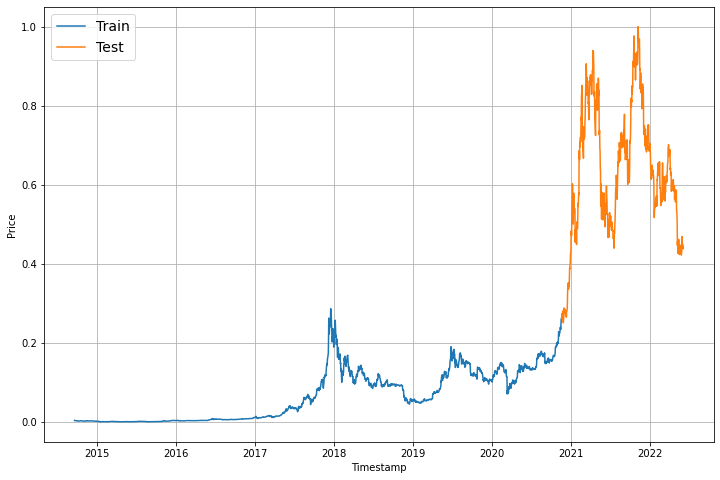

In [26]:
plt.figure(figsize=(12,8)) # Creates a figure and adds the following plot to it
plot_time_series(X_train, Y_train, label= "Train")
plot_time_series(X_test, Y_test, label = "Test")
# It would be interesting to put start and end as the year

Naive baseline model:
$\hat{y}_{t} = y_{t-1}$

In [27]:
naive_forecast = Y_test[:-1] # Gets every value excluding the last value

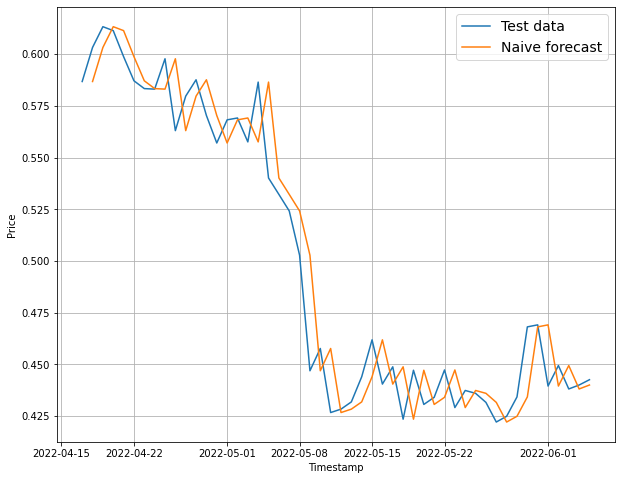

In [28]:
# Comparing naive_forecast with the test data
plt.figure(figsize=(10, 8))
offset = len(X_test)-50
plot_time_series(timesteps=X_test, values=Y_test, start = offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start = offset, format="-", label="Naive forecast");

In [29]:
"""
  returns error metrics in dictionary form
"""
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  }
  return return_dict


In [30]:
naive_results = evaluate_preds(y_true=Y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.018336063,
 'mape': 2.941212,
 'mse': 0.00063651946,
 'rmse': 0.025229337}

In [31]:
"""
  Windowing a dataset, our plan is to predict a price for 1 day
  The following values uses 7 day data to predict 1 day price
"""
HORIZON = 1
WINDOW_SIZE = 7 # We will get this value by hyperparameter tuning later on.


In [32]:
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [33]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    makes windows using numpy arrays' indexing
    returns 2D array of sequential windows of window size
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # -1 to prevent window going off the last value

    # Here window_indexes gives the position of the value of respective indexes, so using x[window_indexes] puts the respective x values in the position
    # specified in the window_indexes. It only works with numpy arrays
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels


In [34]:
"""
  Makes training, validation and test datasets in windows
  80% train, 20% test
"""
boundary1 = int(0.8 * len(timesteps))
prices_train = prices[:boundary1]

prices_test = prices[boundary1:]

len(prices_train), len(prices_test)

(2255, 564)

(2806, 2819)

In [136]:
mean = prices_train.mean()
prices_train.std(), mean

(0.06399364401750054, 0.06605276505814961)

In [137]:
train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )
len(train_windows), len(test_windows)

(2249, 558)

In [37]:
"""
  Since we are comparing different model's performance, it is better to compare each model's best performance with another model's best
  Model's performance is going to fluctuate epoch to epoch
  Create a function to implement a ModelCheckpoint callback with a specific filename 
"""

def create_model_checkpoint(model_name, save_path="models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # elsewise continously printout if saved or not
                                            save_best_only=True)

In [38]:
def early_stopping(): 
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=40,
                                          restore_best_weights=True)

## Finetuning the hyperparameters
First, with a simple dense model, lets try to find out a good value for WINDOW_SIZE and batch_size

In [24]:
for i in range(1, 61):
  WINDOW_SIZE = i

  # Make windowed data with appropriate horizon and window sizes
  train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
  test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )

  tf.random.set_seed(42)
  model_2 = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON, activation="relu")
  ], name="fine_tuning_window_"+str(i))

  model_2.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam())

  model_2.fit(train_windows,
              train_labels,
              epochs=100,
              batch_size=512,
              verbose=0,
              validation_data=(test_windows, test_labels),
              callbacks=[create_model_checkpoint(model_name=model_2.name)])


INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Assets written to: models/fine_tuning_window_1/assets
INFO:tensorflow:Asse

In [25]:
min_loss = -1
WINDOW_SIZE_N = 1
for i in range(1, 61):
  WINDOW_SIZE = i
  test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )
  model = tf.keras.models.load_model("models/fine_tuning_window_" + str(i))
  loss = model.evaluate(test_windows, test_labels)
  if (min_loss>loss): 
    min_loss=loss
    WINDOW_SIZE_N = i
  elif (min_loss == -1): 
    min_loss = loss
    WINDOW_SIZE_N = i
model_name = "models/fine_tuning_window_" + str(WINDOW_SIZE_N)
WINDOW_SIZE = WINDOW_SIZE_N
model_name, min_loss

16/16 [==============================] - 0s 2ms/step - loss: 1670.9417


('models/fine_tuning_window_1', 1235.5826416015625)

In [39]:
WINDOW_SIZE = 6

In [40]:
train_windows, train_labels = make_windows(prices_train, WINDOW_SIZE, HORIZON)
test_windows, test_labels = make_windows(prices_test, WINDOW_SIZE, HORIZON )

**For batch_size**

In [30]:
# Make windowed data with appropriate horizon and window sizes

batch_sizes = [32, 64, 128, 256, 512, 1024]

for i in batch_sizes:
  tf.random.set_seed(42)
  model_tuning = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON, activation="relu")
  ], name="fine_tuning_batch_size_"+str(i))

  model_tuning.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam())

  model_tuning.fit(train_windows,
              train_labels,
              epochs=100,
              batch_size=i,
              verbose=0,
              validation_data=(test_windows, test_labels),
              callbacks=[create_model_checkpoint(model_name=model_tuning.name)])


INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets written to: models/fine_tuning_batch_size_32/assets
INFO:tensorflow:Assets wr

In [31]:
min_loss = -1
BATCH_SIZE = 0
for i in batch_sizes:
  model = tf.keras.models.load_model("models/fine_tuning_batch_size_" + str(i))
  loss = model.evaluate(test_windows, test_labels)
  if (min_loss>loss): 
    min_loss=loss
    BATCH_SIZE = i  
  elif (min_loss == -1): 
    min_loss=loss
    BATCH_SIZE = i  

model_name = "models/fine_tuning_batch_size_" + str(BATCH_SIZE)

model_name, min_loss

18/18 [==============================] - 0s 2ms/step - loss: 1365.0961


('models/fine_tuning_batch_size_64', 1236.349853515625)

In [41]:
BATCH_SIZE = 64

In [42]:
print("Window size is: ", WINDOW_SIZE)
print("Batch size is: ", BATCH_SIZE)

Window size is:  6
Batch size is:  64


In [43]:
""" 
  Model-1: Dense model (window=7, horizon=1)
"""

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='relu')
], name='model_dense') # we can use it for our checkpoint function

# 2. Compile
model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=1000,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[early_stopping()])



Epoch 1/1000
36/36 [==============================] - 3s 8ms/step - loss: 0.0125 - mae: 0.0125 - mse: 4.5594e-04 - val_loss: 0.0311 - val_mae: 0.0311 - val_mse: 0.0016
Epoch 2/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0047 - mae: 0.0047 - mse: 5.6327e-05 - val_loss: 0.0329 - val_mae: 0.0329 - val_mse: 0.0018
Epoch 3/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0037 - mae: 0.0037 - mse: 4.3947e-05 - val_loss: 0.0284 - val_mae: 0.0284 - val_mse: 0.0013
Epoch 4/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0035 - mae: 0.0035 - mse: 4.0613e-05 - val_loss: 0.0319 - val_mae: 0.0319 - val_mse: 0.0016
Epoch 5/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0033 - mse: 3.7746e-05 - val_loss: 0.0264 - val_mae: 0.0264 - val_mse: 0.0012
Epoch 6/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0031 - mse: 3.4965e-05 - val_loss: 0.0257 - val_mae: 0.0257 - val_mse:

In [44]:
# Evaluates on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 0.0184 - mae: 0.0184 - mse: 6.4348e-04


[0.018404841423034668, 0.018404841423034668, 0.0006434842944145203]

In [45]:
## After evaluating the model, lets forecast using the model (it is pseudo forecast)
def make_prediction(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Squeezing is needed because we are returning 1D array of predictions

In [46]:
# Make predictions using model_dense on the test dataset and evaluate it on test data
model_1_prediction = make_prediction(model_1, test_windows)

In [47]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_prediction)
model_1_results

{'mae': 0.018404841,
 'mape': 2.9324107,
 'mse': 0.0006434843,
 'rmse': 0.025366992}

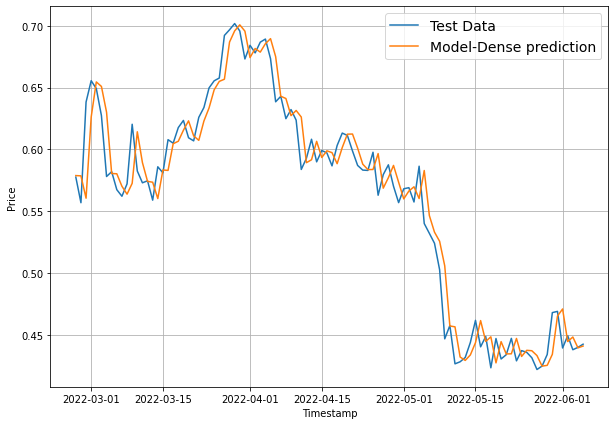

In [48]:
# Plotting model-1 predictions
plt.figure(figsize=(10,7))
offset=len(test_windows)-100
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_prediction, start=offset, label="Model-Dense prediction", format='-')

### Model-2 CNN

In [49]:
tf.random.set_seed(42)

# Create Conv1D model
model_2 = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  # layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  # layers.BatchNormalization(),
  # layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2.fit(train_windows,
            train_labels, 
            batch_size=BATCH_SIZE, 
            epochs=1000, 
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[early_stopping()]
            )

Epoch 1/1000
36/36 [==============================] - 9s 13ms/step - loss: 0.0163 - val_loss: 0.0356
Epoch 2/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0311
Epoch 3/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0301
Epoch 4/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0306
Epoch 5/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0286
Epoch 6/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0278
Epoch 7/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0279
Epoch 8/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0266
Epoch 9/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0260
Epoch 10/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.027

In [50]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 0.0189


0.018915308639407158

In [51]:
# Model predictions
model_2_preds = make_prediction(model_2, test_windows)

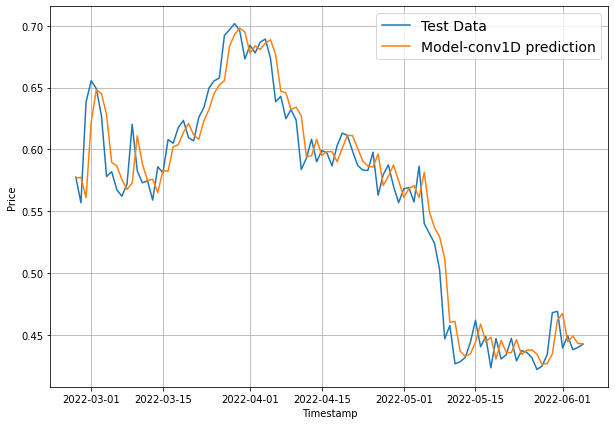

In [52]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, format="-", start=offset, label="Model-conv1D prediction")

In [53]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 0.018915307,
 'mape': 3.0191555,
 'mse': 0.0006702228,
 'rmse': 0.025888663}

# Model 3: RNN (LSTM)

In [54]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
# x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[early_stopping()]
            )



Epoch 1/1000
36/36 [==============================] - 3s 18ms/step - loss: 0.0326 - val_loss: 0.0321
Epoch 2/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0431
Epoch 3/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0484
Epoch 4/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0502
Epoch 5/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0406
Epoch 6/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0034 - val_loss: 0.0299
Epoch 7/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0319
Epoch 8/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0325
Epoch 9/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0296
Epoch 10/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 0.0208


0.020784402266144753

In [56]:
# Make predictions with our LSTM model
model_3_preds = make_prediction(model_3, test_windows)

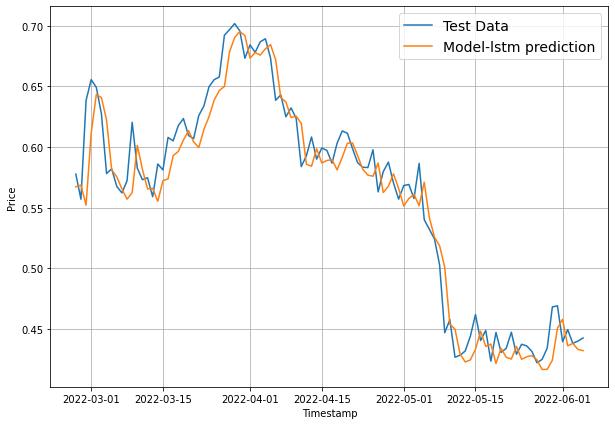

In [57]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, format="-", start=offset, label="Model-lstm prediction")

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 0.020784399,
 'mape': 3.3050559,
 'mse': 0.0007787549,
 'rmse': 0.02790618}

## Multivariate Models

In [59]:
"""
  Creates a bitcoin dataframe
"""
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_updated.csv", parse_dates=["Date"])
df.rename(columns = {"Close": "Price", "Date": "Timestamp"}, inplace = True)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(                  Open        High         Low       Price      Volume
 Timestamp                                                             
 2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0
 2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0
 2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0
 2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0
 2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0,
                    Open         High          Low        Price        Volume
 Timestamp                                                                   
 2022-06-01  31792.55469  31957.28516  29501.58789  29799.08008  4.113582e+10
 2022-06-02  29794.89063  30604.73438  29652.70508  30467.48828  2.908356e+10
 2022-06-03  30467.80664  30633.03516  29375.68945  29704.39063  2.617555e+10
 2022-06-04  29706.13867  29930.56445  29500.00586  29832.91406  1.658837e+10
 2022-06-05  29836.29297  3

In [60]:
#  Windows the dataset directly from the pandas dataframe
"""
  [0,1,2,3,4,5,6,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [7]
  [1,2,3,4,5,6,7,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [8]
"""
btc_windowed_df = btc_df.copy() # copy is needed to avoid pandas warning

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df[f"Price+{i+1}"] = btc_df["Price"].shift(periods=i+1)
btc_windowed_df.head(10)

,Open,High,Low,Price,Volume,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6
Timestamp,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990


In [61]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features
btc_windowed_df = normalize(btc_windowed_df.dropna(), price_mem_multivariate)
x = btc_windowed_df.drop("Price", axis=1).astype(np.float32) # windows
y = btc_windowed_df["Price"].astype(np.float32) # labels
x.head(), y.head()

(                Open      High       Low    Volume   Price+1   Price+2  \
 Timestamp                                                                
 2014-09-23  0.003343  0.003351  0.003394  0.000112  0.003325  0.003275   
 2014-09-24  0.003842  0.003272  0.003770  0.000070  0.003824  0.003325   
 2014-09-25  0.003655  0.003088  0.003594  0.000060  0.003637  0.003824   
 2014-09-26  0.003481  0.002963  0.003451  0.000044  0.003465  0.003637   
 2014-09-27  0.003364  0.002842  0.003411  0.000026  0.003358  0.003465   
 
              Price+3   Price+4   Price+5   Price+6  
 Timestamp                                           
 2014-09-23  0.003425  0.003216  0.003655  0.004144  
 2014-09-24  0.003275  0.003425  0.003216  0.003655  
 2014-09-25  0.003325  0.003275  0.003425  0.003216  
 2014-09-26  0.003824  0.003325  0.003275  0.003425  
 2014-09-27  0.003637  0.003824  0.003325  0.003275  , Timestamp
 2014-09-23    0.003824
 2014-09-24    0.003637
 2014-09-25    0.003465
 2014-09-26 

In [62]:
price_mem_multivariate, price_mem_univariate

({'max_value': 67566.82813, 'min_value': 178.102997},
 {'max_value': 1.0, 'min_value': 0.0})

In [63]:
# 80% train, 205% test
boundary1 = int(0.8 * len(x))
x_train, y_train = x[:boundary1], y[:boundary1]
x_test, y_test = x[boundary1:], y[boundary1:]
len(x_train), len(x_test)

(2250, 563)

In [64]:
# Make model_1_multi
model_1_multi = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name='model_1_multivariate')

model_1_multi.compile(
    loss = "mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = "mae"
)

model_1_multi.fit(x=x_train,
            y=y_train,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping()]
            )

Epoch 1/1000
36/36 [==============================] - 1s 6ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 2/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0026 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 3/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0021 - mae: 0.0021 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 4/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0158 - val_mae: 0.0158
Epoch 5/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0144 - val_mae: 0.0144
Epoch 6/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0149 - val_mae: 0.0149
Epoch 7/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 8/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.

In [65]:
model_1_multi.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0079 - mae: 0.0079


[0.007920621894299984, 0.007920621894299984]

In [66]:
# Make predictions
model_1_multi_preds = tf.squeeze(model_1_multi.predict(x_test))


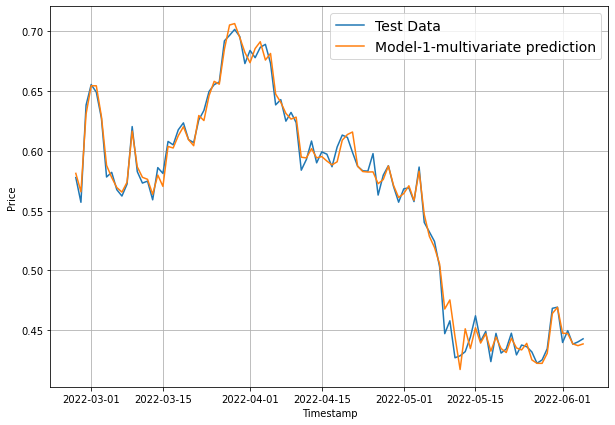

In [67]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test.index.to_numpy(), values=y_test.to_numpy(), format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_1_multi_preds, format="-", start=offset, label="Model-1-multivariate prediction")

In [77]:
#  values=denormalize_price(model_1_multi_preds.numpy(), price_mem_multivariate)

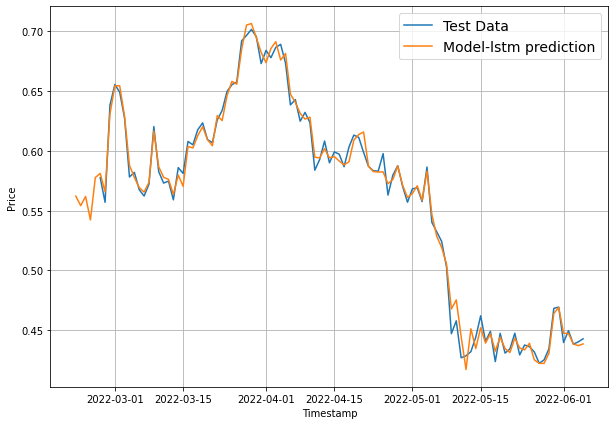

In [78]:
offset=len(test_windows)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_1_multi_preds.numpy(), format="-", start=offset, label="Model-lstm prediction")

In [79]:
model_1_multi_results = evaluate_preds(y_true=y_test, y_pred=model_1_multi_preds)
model_1_multi_results

{'mae': 0.007920622,
 'mape': 1.2596772,
 'mse': 0.000113707436,
 'rmse': 0.010663369}

In [80]:
# # Testing with random
# model_1_multi.predict(tf.expand_dims([402.092010,	441.557007,	396.196991,	450.995000,	402.152008,	398.821014,	408.903992,	394.795990,	424.440002,	457.334015], axis=0))


## Model_CONV1D_Multivariate

In [87]:
tf.random.set_seed(42)

# Create Conv1D model
model_2_multi = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D_multivariate")

# Compile model
model_2_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2_multi.fit(x_train, #if faced data cardinality error, do tf.stack(train_windows) or np.array(train_windows)
            y_train, 
            batch_size=BATCH_SIZE, 
            epochs=1000, 
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping()]
            )

Epoch 1/1000
36/36 [==============================] - 3s 13ms/step - loss: 0.0807 - val_loss: 0.6376
Epoch 2/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0663 - val_loss: 0.6376
Epoch 3/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0662 - val_loss: 0.6376
Epoch 4/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0532 - val_loss: 0.6281
Epoch 5/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0353 - val_loss: 0.5828
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0302 - val_loss: 0.5877
Epoch 7/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0268 - val_loss: 0.5997
Epoch 8/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0225 - val_loss: 0.5945
Epoch 9/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.5000
Epoch 10/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.325

In [88]:
model_2_multi.evaluate(x_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.0119


0.011876234784722328

In [89]:
# Model predictions
model_2_multi_preds = make_prediction(model_2_multi, x_test)

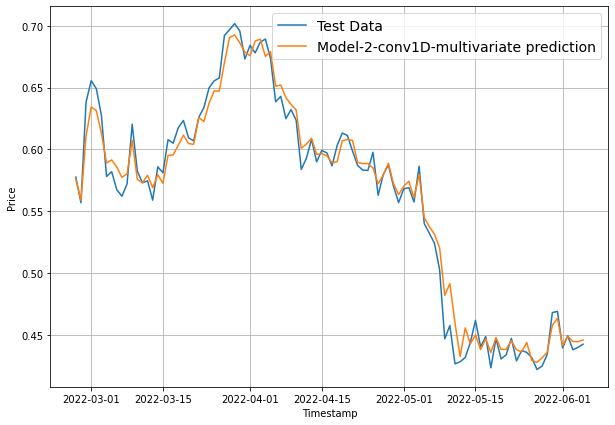

In [90]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test.index.to_numpy(), values=y_test.to_numpy(), format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_2_multi_preds, format="-", start=offset, label="Model-2-conv1D-multivariate prediction")

In [91]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_2_multi_preds)
model_2_results

{'mae': 0.011876235,
 'mape': 1.8658049,
 'mse': 0.00023744418,
 'rmse': 0.015409224}

## LSTM Multivariate Model

In [92]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=x_train.shape[1])
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3_multi = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm_multivariate")

# Compile
model_3_multi.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3_multi.fit(x_train,
            y_train,
            epochs=1000,
            verbose=1,
            batch_size=BATCH_SIZE,
            validation_data=(x_test, y_test),
            callbacks=[early_stopping()]
            )



Epoch 1/1000
36/36 [==============================] - 3s 18ms/step - loss: 0.0276 - val_loss: 0.0528
Epoch 2/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0246
Epoch 3/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0296
Epoch 4/1000
36/36 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0416
Epoch 5/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0579
Epoch 6/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0447
Epoch 7/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0499
Epoch 8/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0414
Epoch 9/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0553
Epoch 10/1000
36/36 [==============================] - 0s 10ms/step - loss: 0.0024 - val_los

In [93]:
model_3_multi.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0148


0.014754469506442547

In [94]:
# Make predictions with our LSTM model
model_3_multi_preds = make_prediction(model_3_multi, x_test)

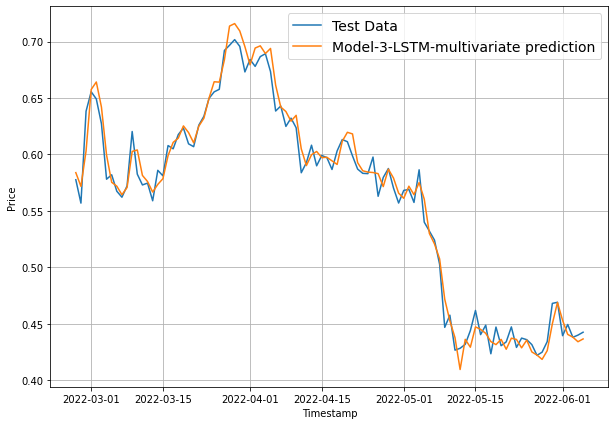

In [95]:
offset=len(x_test)-100
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test.index.to_numpy(), values=y_test.to_numpy(), format="-", start=offset, label="Test Data")
plot_time_series(timesteps=x_test.index.to_numpy(), values=model_3_multi_preds, format="-", start=offset, label="Model-3-LSTM-multivariate prediction")

In [96]:
model_3_results_multi = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_3_multi_preds)
model_3_results_multi

{'mae': 0.0147544695,
 'mape': 2.2239273,
 'mse': 0.00038655032,
 'rmse': 0.019660883}

In [98]:
# Testing with random
# model_3_multi.predict(tf.expand_dims([1,2,3,4,5,6,7,8,9,10,12,12], axis=0))

# Future Predictions

In [118]:
#  Windows the dataset directly from the pandas dataframe
"""
  [0,1,2,3,4,5,6,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [7]
  [1,2,3,4,5,6,7,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [8]
"""
btc_windowed_df = btc_df.copy() # copy is needed to avoid pandas warning

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df[f"Price+{i+1}"] = btc_windowed_df["Price"].shift(periods=i+1)
btc_windowed_df.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6
Timestamp,,,,,,,
2014-09-17,0.004144,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,0.003655,0.004144,NaN,NaN,NaN,NaN,NaN
2014-09-19,0.003216,0.003655,0.004144,NaN,NaN,NaN,NaN
2014-09-20,0.003425,0.003216,0.003655,0.004144,NaN,NaN,NaN
2014-09-21,0.003275,0.003425,0.003216,0.003655,0.004144,NaN,NaN
2014-09-22,0.003325,0.003275,0.003425,0.003216,0.003655,0.004144,NaN
2014-09-23,0.003824,0.003325,0.003275,0.003425,0.003216,0.003655,0.004144
2014-09-24,0.003637,0.003824,0.003325,0.003275,0.003425,0.003216,0.003655
2014-09-25,0.003465,0.003637,0.003824,0.003325,0.003275,0.003425,0.003216


In [119]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features
x = btc_windowed_df.dropna().drop("Price", axis=1).astype(np.float32) # windows
y = btc_windowed_df.dropna()["Price"].astype(np.float32) # labels
x.head(), y.head()

(             Price+1   Price+2   Price+3   Price+4   Price+5   Price+6
 Timestamp                                                             
 2014-09-23  0.003325  0.003275  0.003425  0.003216  0.003655  0.004144
 2014-09-24  0.003824  0.003325  0.003275  0.003425  0.003216  0.003655
 2014-09-25  0.003637  0.003824  0.003325  0.003275  0.003425  0.003216
 2014-09-26  0.003465  0.003637  0.003824  0.003325  0.003275  0.003425
 2014-09-27  0.003358  0.003465  0.003637  0.003824  0.003325  0.003275,
 Timestamp
 2014-09-23    0.003824
 2014-09-24    0.003637
 2014-09-25    0.003465
 2014-09-26    0.003358
 2014-09-27    0.003286
 Name: Price, dtype: float32)

In [160]:
# Number of predictions into future
predictions_n = len(test_windows)

In [162]:
# In the function of predicting the future, there is no test sets
# Train model on entire data to make predictions for the next day
x_all = btc_windowed_df.dropna().drop(["Price"], axis=1).to_numpy()[:-predictions_n]

# Get labels
y_all = btc_windowed_df.dropna()["Price"][:-predictions_n]

len(x_all), len(y_all)

(2255, 2255)

In [163]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE=1024
# tf.data.AUTOTUNE automatically prefetches the data on CPU as best as it can
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [164]:
""" 
  Future-Model-1: Dense model (window=7, horizon=1)
"""

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

future_model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='relu')
], name='future_pred_model') # we can use it for our checkpoint function

# 2. Compile
future_model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
future_model_1.fit(dataset_all,
            epochs=300,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=BATCH_SIZE,
            )



Epoch 1/300
3/3 [==============================] - 1s 7ms/step - loss: 0.0389 - mae: 0.0389 - mse: 0.0030
Epoch 2/300
3/3 [==============================] - 0s 20ms/step - loss: 0.0275 - mae: 0.0275 - mse: 0.0012
Epoch 3/300
3/3 [==============================] - 0s 15ms/step - loss: 0.0191 - mae: 0.0191 - mse: 4.8990e-04
Epoch 4/300
3/3 [==============================] - 0s 11ms/step - loss: 0.0212 - mae: 0.0212 - mse: 5.5399e-04
Epoch 5/300
3/3 [==============================] - 0s 6ms/step - loss: 0.0251 - mae: 0.0251 - mse: 7.1015e-04
Epoch 6/300
3/3 [==============================] - 0s 9ms/step - loss: 0.0216 - mae: 0.0216 - mse: 5.4149e-04
Epoch 7/300
3/3 [==============================] - 0s 10ms/step - loss: 0.0153 - mae: 0.0153 - mse: 2.9636e-04
Epoch 8/300
3/3 [==============================] - 0s 13ms/step - loss: 0.0112 - mae: 0.0112 - mse: 1.8069e-04
Epoch 9/300
3/3 [==============================] - 0s 9ms/step - loss: 0.0085 - mae: 0.0085 - mse: 1.2441e-04
Epoch 10/300


In [149]:
# Need to think of an way for this multi-variate model

In [186]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts for into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for i in range(into_future):
    # Model will eventually make future forecasts based on its past forecasts.
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    # print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds 
    # provided that model was trained on WINDOW_SIZE window
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [187]:
# Make forecasts into the future
future_forecast_1 = make_future_forecasts(values=y_all,
                                        model=future_model_1,
                                        into_future=predictions_n,
                                        window_size=WINDOW_SIZE)

In [188]:
# len(future_forecast_1), predictions_n

In [189]:
timestamps = btc_windowed_df.tail(predictions_n).index.to_numpy()
prices = btc_windowed_df.tail(predictions_n)['Price'].to_numpy()

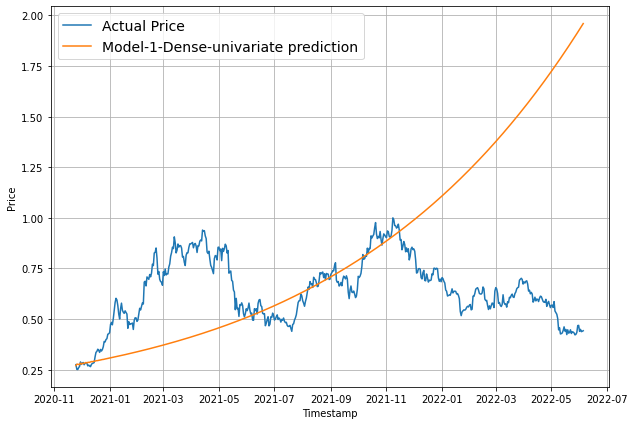

In [197]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps, values=prices, format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps, values=future_forecast_1, format="-", start=offset, label="Model-1-Dense-univariate prediction")

## Future Model-2

In [199]:
tf.random.set_seed(42)

# Create Conv1D model
future_model_2 = tf.keras.Sequential([

  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  
  layers.Conv1D(filters=256, kernel_size=8, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
  layers.BatchNormalization(),
  layers.Activation(activation='relu'),

  layers.GlobalAveragePooling1D(),
  layers.Dense(HORIZON, activation="relu")

], name="model_conv1D")

# Compile model
future_model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
future_model_2.fit(dataset_all, 
                  epochs=200, 
                  verbose=1,
                  batch_size=BATCH_SIZE, 
                  )

Epoch 1/200
3/3 [==============================] - 2s 10ms/step - loss: 0.3124
Epoch 2/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1211
Epoch 3/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0620
Epoch 4/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0593
Epoch 5/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0474
Epoch 6/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0495
Epoch 7/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0447
Epoch 8/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0497
Epoch 9/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0498
Epoch 10/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0435
Epoch 11/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0481
Epoch 12/200
3/3 [==============================] - 0s 15ms/step - loss: 0.0424
Epoch 13/200
3/3 [==============================] - 0s

In [200]:
# Make forecasts into the future
future_forecast_2 = make_future_forecasts(values=y_all,
                                        model=future_model_2,
                                        into_future=predictions_n,
                                        window_size=WINDOW_SIZE)

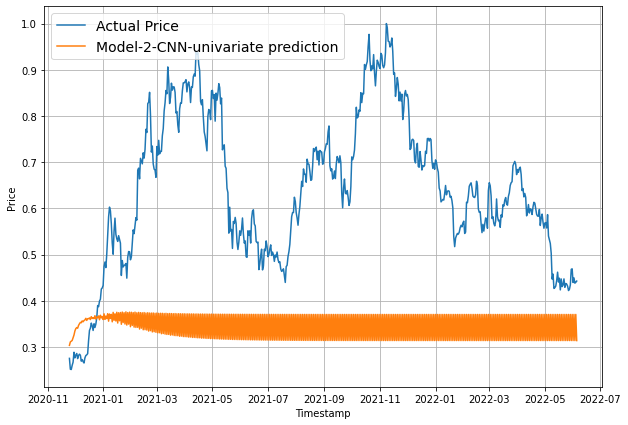

In [201]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps, values=prices, format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps, values=future_forecast_2, format="-", start=offset, label="Model-2-CNN-univariate prediction")

## Future Model-3

In [185]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.Bidirectional(layers.LSTM(128, activation="relu"))(x)
# x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
future_model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# Compile
future_model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
future_model_3.fit(dataset_all,
            epochs=200,
            verbose=1,
            batch_size=BATCH_SIZE,
            )



Epoch 1/200
3/3 [==============================] - 3s 10ms/step - loss: 0.0616
Epoch 2/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0539
Epoch 3/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0495
Epoch 4/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0455
Epoch 5/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0420
Epoch 6/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0391
Epoch 7/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0369
Epoch 8/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0351
Epoch 9/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0349
Epoch 10/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0363
Epoch 11/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0377
Epoch 12/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0359
Epoch 13/200
3/3 [==============================]

In [192]:
# Make forecasts into the future
future_forecast_3 = make_future_forecasts(values=y_all,
                                        model=future_model_3,
                                        into_future=predictions_n,
                                        window_size=WINDOW_SIZE)

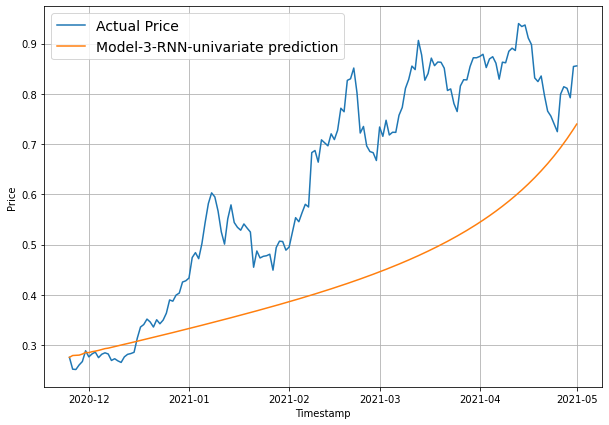

In [206]:
offset=0
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timestamps[:-400], values=prices[:-400], format="-", start=offset, label="Actual Price")
plot_time_series(timesteps=timestamps[:-400], values=future_forecast_3[:-400], format="-", start=offset, label="Model-3-RNN-univariate prediction")